In [1]:
# run the header that sets up the environment

if "already_run" not in globals():
    globals()["already_run"] = True
    
    %run header.ipynb
    load_packages()
    change_wordir()

colors, colours = colourblind_palette("own")

analysis = "PIRKs"

#model = "cyclic_2021"
#model = "new_PSI"
# model = "new_PSII"
# model = "new_b6f"
model = "latest_dev"

m = load_model(model)

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0

succesfully loaded latest_dev :D


In [2]:
y0 = {
    "PQ": 11.027139850905353,       "PC": 1.8895071932002812,           "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,       "NADPH": 0.48821037006737366,       "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,      "Psbs": 0.9607146039898598,         "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,      "BPGA": 0.0005355311557548053,      "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,    "FBP": 0.006126990841013743,        "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,      "G1P": 0.041575582577936025,        "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,     "E4P": 0.00732079113061801,         "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,     "RUBP": 0.13153657267999222,        "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,    "ASC": 9.999994138785292,           "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,   "GSH": 9.999999991725186,           "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,                   "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
    "B0": 1,
    "B1": .25,
    "B2": 1
}

In [3]:
def PIRK(s: Simulator, ss_pfd: float, dark_pfd: float, pulse_pfd: float,
          pulse_time: float, relax_time: float, time_delay= bool):
     """
     steady state (light) -> dark -> light pulses (fast)
     """

     s.update_parameter("pfd", ss_pfd)
     s.simulate(100)
     s.update_parameter("pfd", dark_pfd)
     s.simulate(160)

     # Define pulsed sequence (alternating pulse/dark PFDs)
     pfds = list([pulse_pfd, dark_pfd]*4)  
     
     # define the intervals
     if time_delay:
          time_points = list(it.accumulate(it.chain.from_iterable(
               (pulse_time, relax_time * factor) for factor in [1, 2, 4, 0.5]
          )))
     else:
          time_points = list(it.accumulate([pulse_time, relax_time]*4)) 
     
     # Adjust all time points by adding the initial dark period (160s)
     time_points = [t + 160 for t in time_points]

     for t, pfd in tqdm(zip(time_points, pfds)):
          #print(f"Time: {t}, PFD: {pfd}")
          s.update_parameter("pfd", pfd)
          s.simulate(t)

     return s.get_full_results_df(), s.get_fluxes_df(), time_points


# simlulation

In [4]:
##to be similar to behavior time_relax=0.05, time_pulse = 0.005, pfd_dark=100, pfd_pulse=450, normal_light=400

s1 = Simulator(m)
s1.initialise(y0)

ss_pfd = 90
dark_pfd = 10
pulse_pfd = 5000 #1180
pulse_time = 0.003
relax_time = 0.06
time_delay = False

c, v, t_points = PIRK(s1, ss_pfd, dark_pfd, pulse_pfd, pulse_time, relax_time, time_delay)

dark_periods = [[t_points[i], t_points[i+1]] for i in range(0, len(t_points)-1, 2)]
t_points, dark_periods

8it [00:05,  1.42it/s]


([160.003, 160.063, 160.066, 160.126, 160.129, 160.189, 160.192, 160.252],
 [[160.003, 160.063],
  [160.066, 160.126],
  [160.129, 160.189],
  [160.192, 160.252]])

# Fluorescence signal  

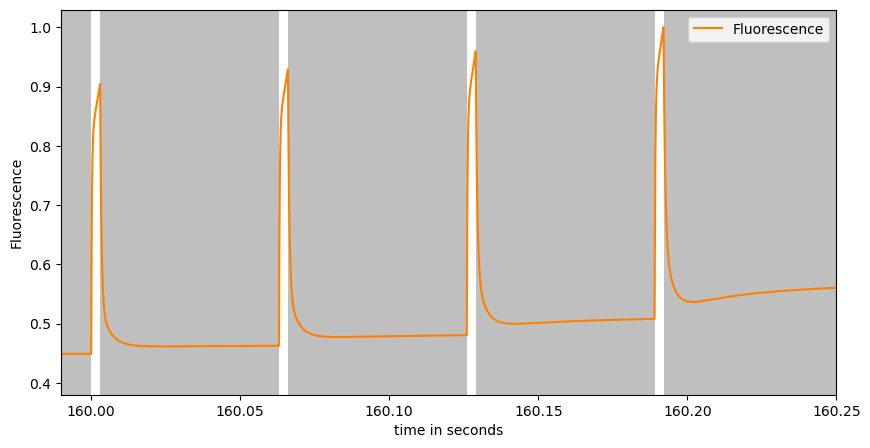

In [5]:
# Fluorescence

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(c["Fluo"]/max(c["Fluo"]), label="Fluorescence", color=colours["orange"])
ax.set(ylabel=("Fluorescence"))
ax.set(xlim=(159.99,160.25),
       #ylim=(0.16,0.5),
       xlabel=("time in seconds"),
       ylabel=("Fluorescence"))

ax.axvspan(100, 160, color='grey', alpha=0.5, lw=0)
for start, end in dark_periods:
       ax.axvspan(start, end, color='grey', alpha=0.5, lw=0)
ax.legend()
plt.show()

In [6]:
save_fig(fig, model, analysis, "Fluorescence")

# PSI states

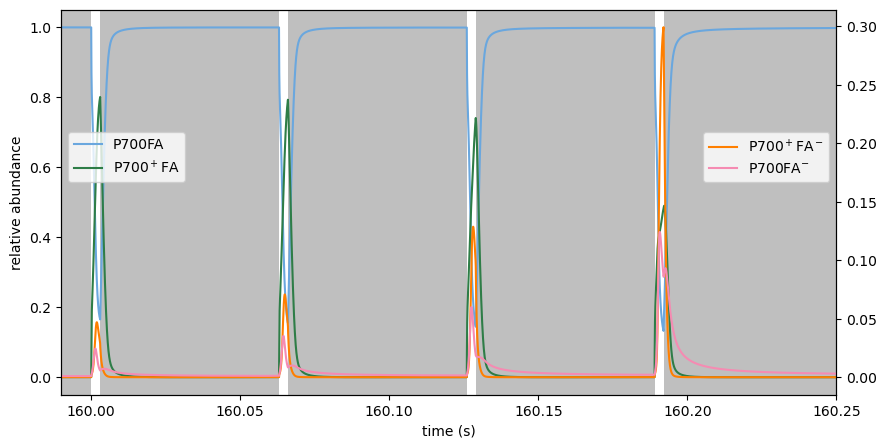

In [7]:
#PSI

fig,ax1=plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.plot(c["rel_P700FA"], label="P700FA", color=colors[0])
ax2.plot(c["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1])
ax1.plot(c["rel_P700+FA"], label="P700$^+$FA", color=colors[2])

if model != "cyclic_2021":
       ax2.plot(c["rel_P700FA-"], label="P700FA$^{-}$", color=colors[3])

#dark periods
ax1.axvspan(100, 160, color='grey', alpha=0.5, lw=0)
for start, end in dark_periods:
       ax1.axvspan(start, end, color='grey', alpha=0.5, lw=0)

ax1.set(xlim=(159.99,160.25),
       #xlim=(159.999999, 160.000002),
       #ylim=(0.16,0.5),
       xlabel=("time (s)"),
       ylabel=("relative abundance"))

#legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.7))
ax2.legend(loc = "upper right", bbox_to_anchor=(1, 0.7))

#ax1.set_yscale("log")
fig.show()

In [8]:
save_fig(fig, model, analysis, "PSI_states")

# PSII states

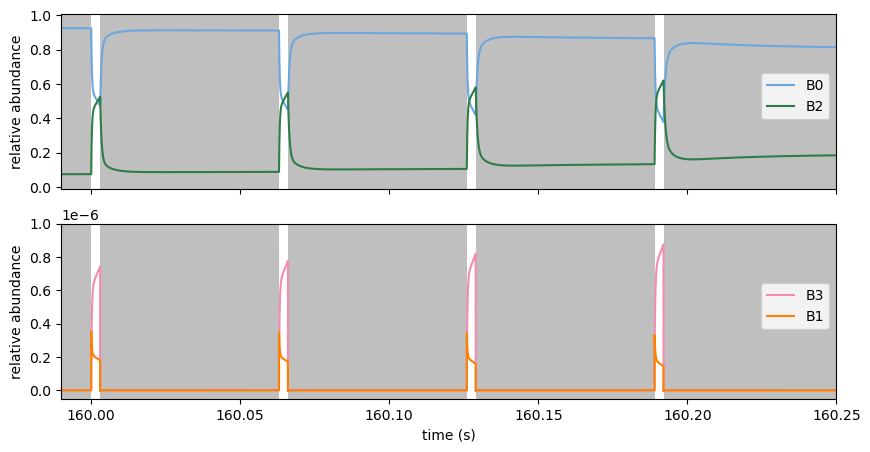

In [9]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,5), sharex=True)
#ax2 = ax1.twinx()

ax1.plot(c["rel_B0"], label="B0", color=colors[0])
ax1.plot(c["rel_B2"], label="B2", color =colors[2])
ax2.plot(c["rel_B3"], label="B3", color=colors[3])
ax2.plot(c["rel_B1"], label="B1", color=colors[1])

#dark periods
for ax in (ax1, ax2):
    ax.axvspan(100, 160, color='grey', alpha=0.5, lw=0)
    for start, end in dark_periods:
        ax.axvspan(start, end, color='grey', alpha=0.5, lw=0)

ax1.set(xlim=(159.99,160.25),
    #xlim=(159.9995, 160.004),
    #ylim=(0.16,0.5),
    ylabel=("relative abundance"))

#ax2.set_yscale("log")
ax2.set(xlim=(159.99,160.25),
    #xlim=(159.9995, 160.004),
    ylim=(-.00000005, 0.000001),
    xlabel=("time (s)"),
    ylabel=("relative abundance"))

#legends
ax1.legend(loc="upper right", bbox_to_anchor=(1, 0.7))
ax2.legend(loc = "upper right", bbox_to_anchor=(1, 0.7))

fig.show()

In [10]:
save_fig(fig, model, analysis, "PSII_states")

# ATP-synthase

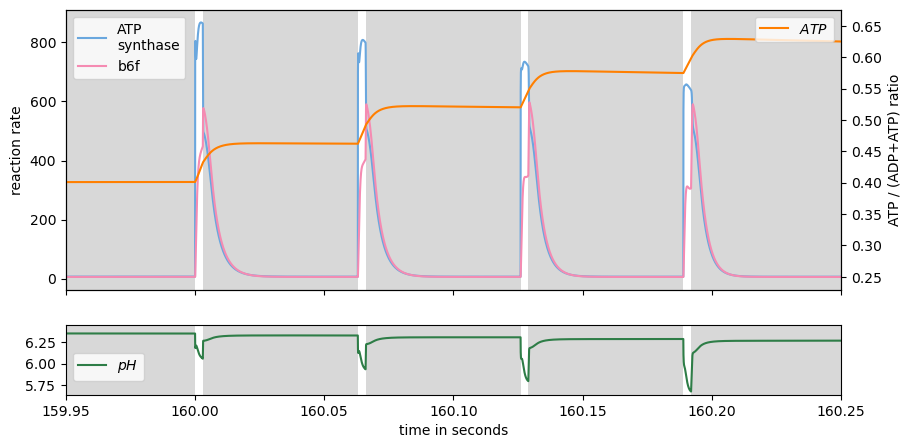

In [11]:
#ATP synthase

fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex = True, gridspec_kw={'height_ratios': [0.8, 0.2]})
ax11 = ax1.twinx()

ax1.set_ylabel("reaction rate")
ax1.plot(v["vATPsynthase"], color=colors[0], label="ATP\nsynthase")
ax1.plot(v["vB6f"], color=colors[3], label="b6f")

ax11.set(ylabel=("ATP / (ADP+ATP) ratio"))
ax11.plot(c["ATP_norm"], color=colors[1], label="$ATP$")

ax2.plot(c["pH"], color=colors[2], label="$pH$")

ax2.set(xlim=(159.95,160.25),
       #xlim=(159.9995, 160.004),
       #ylim=(0.16,0.5),
       xlabel=("time in seconds"))

# dark periods
for ax in [ax1, ax2]:
       ax.axvspan(100, 160, color='grey', alpha=0.3, lw=0)
       for start, end in dark_periods:
              ax.axvspan(start, end, color='grey', alpha=0.3, lw=0)
       
ax1.legend(loc="upper left", bbox_to_anchor=(0, 1))
ax11.legend(loc="upper right", bbox_to_anchor=(1, 1))
ax2.legend(loc="upper left", bbox_to_anchor=(0, 0.7))

fig.show()

In [12]:
save_fig(fig, model, analysis, "ATP_synthase")

# electron carriers

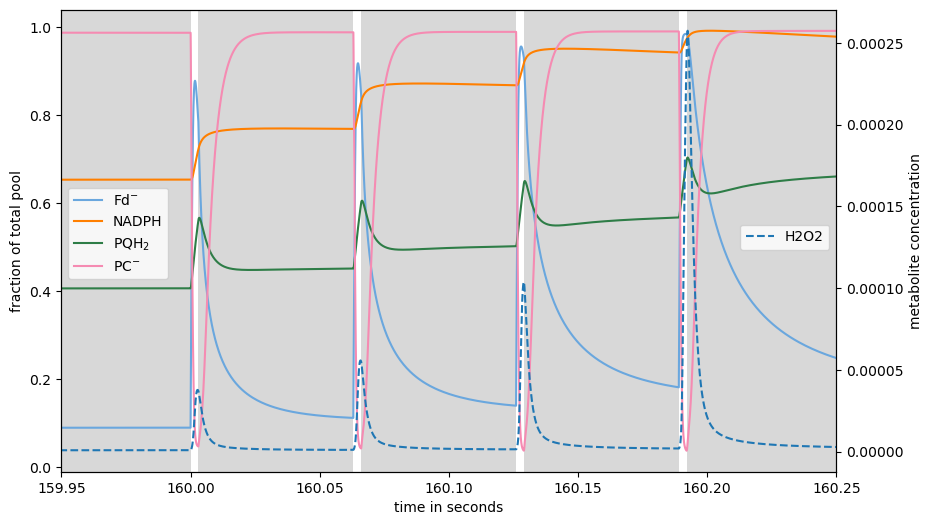

In [13]:
#electron carriers

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(c["Fd_redoxstate"], label = "Fd$^{-}$", color=colors[0])
ax1.plot(c["NADP_redoxstate"], label = "NADPH", color=colors[1])
ax1.plot(c["PQ_redoxstate"], label = "PQH$_{2}$", color=colors[2])
ax1.plot(c["PC_redoxstate"], label = "PC$^{-}$", color=colors[3])

ax2 = c.loc[:,["H2O2"]].plot(ax = ax2, linestyle = "--")

ax1.set(xlim=(159.95,160.25),
        #ylim=(0.16,0.5),
        xlabel=("time in seconds"),
        ylabel=("fraction of total pool"))
ax2.set(ylabel=("ATP / (ADP+ATP) ratio"))

ax2.set_ylabel("metabolite concentration")
ax2.tick_params(axis='y')

ax1.set_ylabel("fraction of total pool")
ax1.tick_params(axis='y')

ax1.axvspan(100, 160, color='grey', alpha=0.3, lw=0)
for start, end in dark_periods:
        ax1.axvspan(start, end, color='grey', alpha=0.3, lw=0)

ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.63))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.55))

In [14]:
save_fig(fig, model, analysis, "electron_carriers")

# PSI and electron carriers

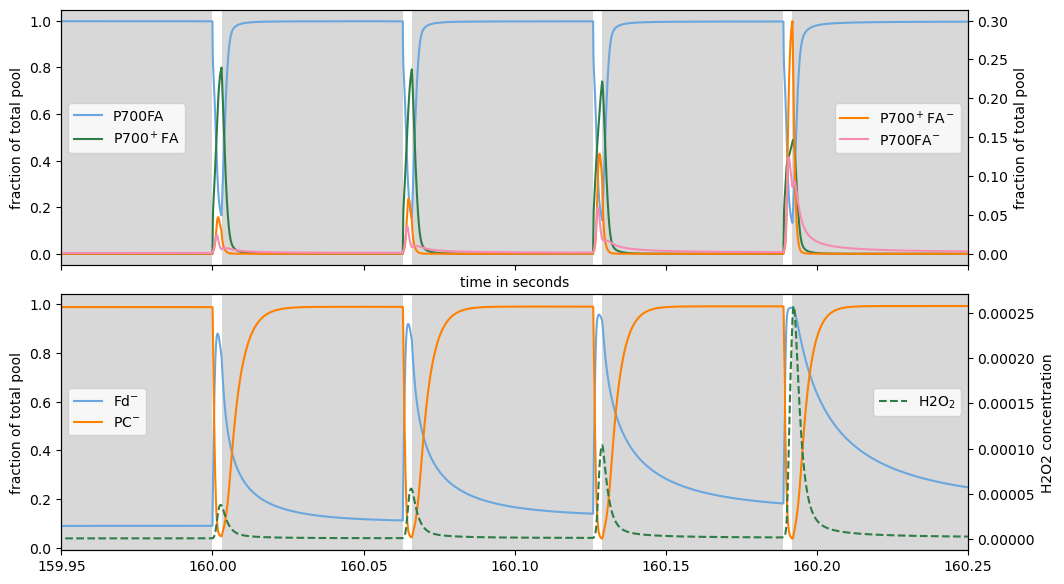

In [15]:
# PSI + electron carriers

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax11 = ax1.twinx()
ax21 = ax2.twinx()
fig.tight_layout()

ax1.plot(c["rel_P700FA"], label="P700FA", color=colors[0])
ax11.plot(c["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1])
ax1.plot(c["rel_P700+FA"], label="P700$^+$FA", color =colors[2])
if model != "cyclic_2021":
        ax11.plot(c["rel_P700FA-"], label = "P700FA$^{-}$", color=colors[3])

ax2.plot(c["Fd_redoxstate"], label = "Fd$^{-}$", color=colors[0])
ax2.plot(c["PC_redoxstate"], label = "PC$^{-}$", color=colors[1])

ax21.plot(c["H2O2"], label = "H2O$_{2}$", linestyle ="--", color=colors[2])

ax1.set(xlim=(159.95,160.25),
        #ylim=(0.16,0.5),
        xlabel=("time in seconds"),
        ylabel=("fraction of total pool"))
ax11.set_ylabel("fraction of total pool")
ax2.set_ylabel("fraction of total pool")
ax21.set_ylabel("H2O2 concentration")

for ax in [ax1, ax2]:
        ax.axvspan(100, 160, color='grey', alpha=0.3, lw=0)
        for start, end in dark_periods:
                ax.axvspan(start, end, color='grey', alpha=0.3, lw=0)

ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.66))
ax11.legend(loc='upper right', bbox_to_anchor=(1, 0.66))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.66))
ax21.legend(loc='upper right', bbox_to_anchor=(1, 0.66))

fig.show()

In [16]:
save_fig(fig, model, analysis, "PSI_and_electron_carriers")

# Calvin cycle intermediates

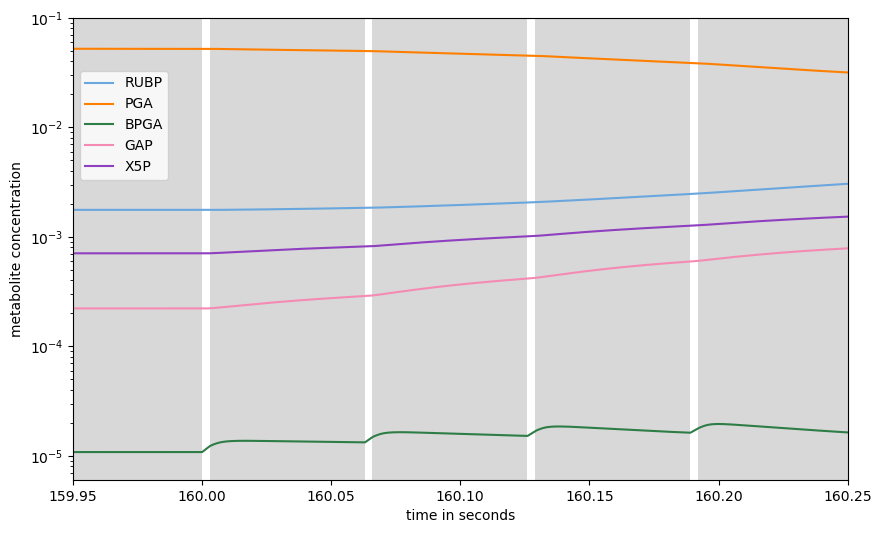

In [17]:
# Calvin cycle intermediates

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

ax1.set_ylabel("metabolite concentration")
ax1.plot(c["RUBP"], label = "RUBP", color=colors[0])
ax1.plot(c["PGA"], label = "PGA", color=colors[1])
ax1.plot(c["BPGA"], label = "BPGA", color=colors[2])
ax1.plot(c["GAP"], label = "GAP", color=colors[3])
ax1.plot(c["X5P"], label = "X5P", color=colors[4])

for ax in [ax1]:
        ax.axvspan(100, 160, color='grey', alpha=0.3, lw=0)
        for start, end in dark_periods:
                ax.axvspan(start, end, color='grey', alpha=0.3, lw=0)

ax1.set(yscale="log")
ax1.set(xlim=(159.95,160.25),
        ylim=(0,0.1),
        xlabel=("time in seconds"))

ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

fig.show()


In [18]:
save_fig(fig, model, analysis, "CBBC_intermediates")

# next plot